In [1]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
from datetime import timezone
import pickle

register_matplotlib_converters()

# File locations
#----------------
the_gases = './oxaria/data/raw/0oxaria/'
aurn = './oxaria/data/aurn/'
pngs = './oxaria/data/pngs/'


In [2]:
aurn_dat = pd.read_feather(aurn+'ox_auto_no2_pm_2019_2020_15m_last_ratified.ftr')
aurn_dat.head()

,sitecode,name,rec,no_ppb,no2_ppb,pm10_ugg,o3_ppb,pm25_ugg,fidas_t,fidas_rh
0,OX,Oxford Centre Roadside,2019-01-01 00:15:00+00:00,6.930000,11.450000,NaN,NaN,NaN,NaN,NaN
1,OX,Oxford Centre Roadside,2019-01-01 00:30:00+00:00,16.469999,20.299999,NaN,NaN,NaN,NaN,NaN
2,OX,Oxford Centre Roadside,2019-01-01 00:45:00+00:00,7.370000,16.110001,NaN,NaN,NaN,NaN,NaN
3,OX,Oxford Centre Roadside,2019-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OX,Oxford Centre Roadside,2019-01-01 01:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Load 15-minute data from Brian
sebbes = pd.read_feather(aurn+'ox_auto_no2_pm_2019_2020_15m_last_ratified.ftr')

# Get St Ebbes 2020 only 
sebbes = aurn_dat[(aurn_dat['sitecode'] == 'OX8') & \
                (aurn_dat['rec'] >= dt.datetime(2020,1,1,tzinfo=dt.timezone.utc))]

# Load 5-minute data from Brian
highst = pd.read_feather(aurn+'ox_auto_no2_pm_2019_2020_15m_last_ratified.ftr')

# Get High St 2020 only 
highst = aurn_dat[(aurn_dat['sitecode'] == 'OX6') & \
                (aurn_dat['rec'] >= dt.datetime(2020,1,1,tzinfo=dt.timezone.utc))]


In [4]:
sebbes.head()

,sitecode,name,rec,no_ppb,no2_ppb,pm10_ugg,o3_ppb,pm25_ugg,fidas_t,fidas_rh
175389,OX8,Oxford St Ebbes,2020-01-01 00:15:00+00:00,0.67,12.28,36.299999,15.73,29.056700,6.2,91.500000
175390,OX8,Oxford St Ebbes,2020-01-01 00:30:00+00:00,0.86,12.76,38.700001,13.41,33.113300,6.1,92.000000
175391,OX8,Oxford St Ebbes,2020-01-01 00:45:00+00:00,0.67,12.95,40.700001,10.52,35.000099,6.1,91.900002
175392,OX8,Oxford St Ebbes,2020-01-01 01:00:00+00:00,NaN,NaN,36.099998,9.17,30.660500,6.1,91.099998
175393,OX8,Oxford St Ebbes,2020-01-01 01:15:00+00:00,NaN,NaN,36.900002,8.78,31.415199,5.9,90.699997


In [5]:
highst.head()

,sitecode,name,rec,no_ppb,no2_ppb,pm10_ugg,o3_ppb,pm25_ugg,fidas_t,fidas_rh
105214,OX6,Oxford High St,2020-01-01 00:15:00+00:00,3.37,14.36,47.400002,NaN,NaN,NaN,NaN
105215,OX6,Oxford High St,2020-01-01 00:30:00+00:00,6.23,16.76,47.700001,NaN,NaN,NaN,NaN
105216,OX6,Oxford High St,2020-01-01 00:45:00+00:00,7.56,18.07,35.799999,NaN,NaN,NaN,NaN
105217,OX6,Oxford High St,2020-01-01 01:00:00+00:00,NaN,NaN,32.799999,NaN,NaN,NaN,NaN
105218,OX6,Oxford High St,2020-01-01 01:15:00+00:00,NaN,NaN,32.400002,NaN,NaN,NaN,NaN


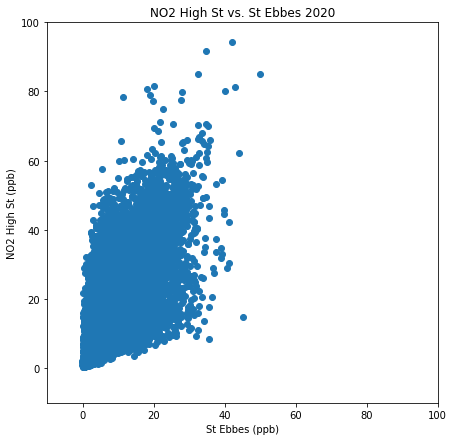

In [6]:
# Plotting just to compare high st vs st ebbes
#----------------------------------------------
plt.figure(figsize=(7,7))
plt.scatter(sebbes.no2_ppb, highst.no2_ppb)
plt.title('NO2 High St vs. St Ebbes 2020')
plt.ylabel('NO2 High St (ppb)')
plt.xlabel('St Ebbes (ppb)')
plt.ylim(-10,100)
plt.xlim(-10,100)
plt.savefig(pngs+'highst_vs_sebbes_2020_ratified.png')

In [7]:
# Plotting just to compare high st vs st ebbes
#----------------------------------------------
#plt.figure(figsize=(7,7))
#plt.scatter(sebbes.no2_ppb, highst.no2_ppb)
#plt.title('NO2 High St vs. St Ebbes 2020')
#plt.ylabel('NO2 High St (ppb)')
#plt.xlabel('St Ebbes (ppb)')
#plt.ylim(-10,100)
#plt.xlim(-10,100)
#plt.savefig(pngs+'highst_vs_sebbes_2020.png')

In [8]:
# Merge St Ebbes & High St auto datasets & calc diff in no2 & pm10
#------------------------------------------------------------------

# Merge
#auto_merged = sebbes.merge(highst,on='rec',copy=True,suffixes=('_s','_h'))
# Calc absolute diffs of no2 & pm10
#auto_merged['abs_no2_diff'] = abs(auto_merged['no2_ppb_s']-auto_merged['no2_ppb_h'])
#auto_merged['abs_pm10_diff'] = abs(auto_merged['pm10_ugg_s']-auto_merged['pm10_ugg_h'])
# Get list of dates when diffs <=1ppb & 2ugm-3 respectively
#convergent_no2 = list(auto_merged.query('abs_no2_diff <= 1')['rec'])
#convergent_pm10 = list(auto_merged.query('abs_pm10_diff <= 2')['rec'])
#auto_merged.to_feather(the_gases+'auto_merged_ratified.ftr')

# Save lists as pickle files to be used later
#with open(the_gases+'convergent_datelist_no2_ratified.pkl', 'wb') as f:
#    pickle.dump(convergent_no2, f)
    
#with open(the_gases+'convergent_datelist_pm10_ratified.pkl', 'wb') as f:
#    pickle.dump(convergent_pm10, f)

# For info
#print('No.of 15min periods across Oxaria network where no2 diff is <= 2ugm-3: '+str(len(convergent_no2)))
#print('No.of 15min periods across Oxaria network where pm10 diff is <= 2ugm-3: '+str(len(convergent_pm10)))


In [9]:
# Merge St Ebbes & High St auto datasets & calc diff in no2 & pm10
#------------------------------------------------------------------

# Merge
auto_merged = sebbes.merge(highst,on='rec',copy=True,suffixes=('_s','_h'))
# Calc absolute diffs of no2 & pm10
auto_merged['abs_no2_diff'] = abs(auto_merged['no2_ppb_s']-auto_merged['no2_ppb_h'])
auto_merged['abs_pm10_diff'] = abs(auto_merged['pm10_ugg_s']-auto_merged['pm10_ugg_h'])
# Get list of dates when diffs <=1ppb & 2ugm-3 respectively
convergent_no2 = list(auto_merged.query('abs_no2_diff <= 1')['rec'])
convergent_pm10 = list(auto_merged.query('abs_pm10_diff <= 2')['rec'])
auto_merged.to_feather(the_gases+'auto_merged_ratified.ftr')

# Save lists as pickle files to be used later
with open(the_gases+'convergent_datelist_no2_ratified.pkl', 'wb') as f:
    pickle.dump(convergent_no2, f)
    
with open(the_gases+'convergent_datelist_pm10_ratified.pkl', 'wb') as f:
    pickle.dump(convergent_pm10, f)

# For info
print('No.of 15min periods across Oxaria network where no2 diff is <= 2ugm-3: '+str(len(convergent_no2)))
print('No.of 15min periods across Oxaria network where pm10 diff is <= 2ugm-3: '+str(len(convergent_pm10)))


No.of 15min periods across Oxaria network where no2 diff is <= 2ugm-3: 2474
No.of 15min periods across Oxaria network where pm10 diff is <= 2ugm-3: 5996
